<a href="https://colab.research.google.com/github/jairo1192/SSC/blob/main/RedNeuronalClasificacionDT0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importamos tensorflow y ts datasets
import tensorflow as tf
import tensorflow_datasets as tfds


In [2]:
#importamos el dataset de imagenes utiizando tensorflow_datasets
datos, metadatos = tfds.load('fashion_mnist', as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteVUSDG0/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteVUSDG0/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
#imprimimos la informacion de los metadatos para ver los valores del set descargado
metadatos

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_path=PosixGPath('/tmp/tmpz6m6yh_ltfds'),
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao a

In [4]:
#ponemos cada conjunto de datos en una variable diferente para utilizarlos
datos_entrenamiento, datos_pruebas = datos['train'], datos['test']

In [5]:
#Asignamos a una variable los nombres de las categorias del set para visualizarlas
nombres_clases = metadatos.features['label'].names

In [6]:
#Imprimimos la variable para ver los nombres de las categorias
nombres_clases

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
#Normalizamos los datos con una funcion para ayudar al entrenamiento (pasar de 0-255 a 0-1)
def normalizar(imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32)
  imagenes /= 255 #Aqui pasa de 0-255 a 0-1
  return imagenes, etiquetas

#Normalizamos los datos a traves de la funcion
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

#Agregamos los datos a cache para agilizar el entrenamiento (usar memoria en lugar de disco)
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

print(datos_entrenamiento)

<CacheDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


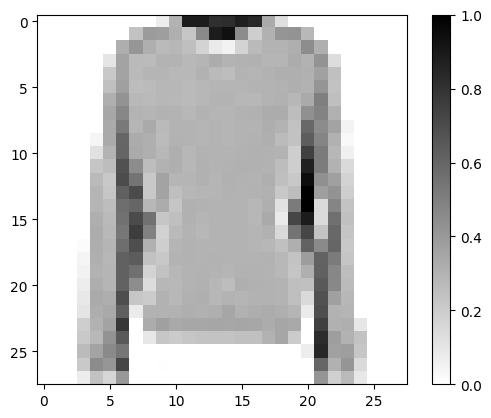

In [8]:
#Mostramos una imagen de los datos de prueba, la primera imagen
for imagen, etiqueta in datos_entrenamiento.take(1):
  break
imagen = imagen.numpy().reshape((28,28)) #Redimensionamos la imagen

import matplotlib.pyplot as plt

#Dibujamos la imagen
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

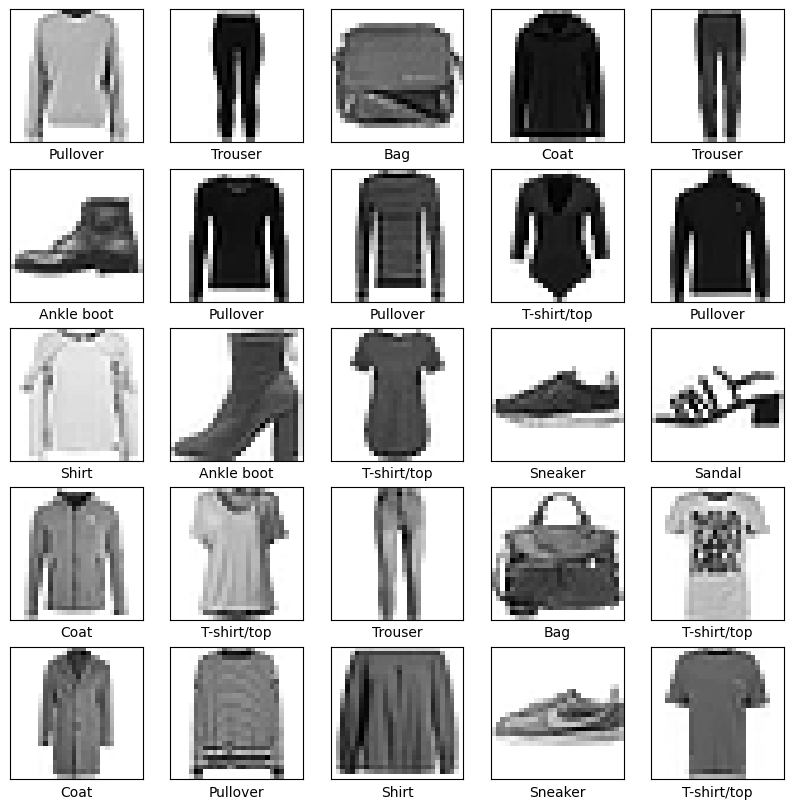

In [9]:
#Imprimiremos mas imagenes para ver cual es la categoria con la que vienen etiquetadas
plt.figure(figsize=(10,10))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
  imagen = imagen.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap=plt.cm.binary)
  plt.xlabel(nombres_clases[etiqueta])
plt.show()

In [10]:
#from keras.layers.serialization import activation
#Hacemos el modelo, red de tipo secuencial
modelo = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)),#Definimos la capa de entrada como Flatten y especificamos los parametros
    tf.keras.layers.Dense(50, activation="relu"),#Agregamos dos capas ocultas densas con 50 neuronas cada una
    tf.keras.layers.Dense(50, activation="relu"),#Cada capa con la activacion relu
    tf.keras.layers.Dense(10, activation="softmax")#Agregamos la capa de salida con 10 neuronas y la activacion softmax 
    #funcion de activacion en capa de salida para redes de clasificacion, asi asegurar que la suma de las redes de salida siempre de 1
])
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 50)                39250     
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
Total params: 42,310
Trainable params: 42,310
Non-trainable params: 0
_________________________________________________________________


In [11]:
#Compilamos el modelo
modelo.compile(
    optimizer='adam',#usamos adam como optimizador
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [12]:
#Definimos variables para los datos de entrenamiento y pruebas y asi utilizarlos
num_ej_entrenamiento = metadatos.splits["train"].num_examples
num_ej_pruebas = metadatos.splits["test"].num_examples

In [13]:
#Imprimimos las variables para ver la cantidad de datos
print(num_ej_entrenamiento)
print(num_ej_pruebas)

60000
10000


In [14]:
#Definimos lotes de entrenamiento para la red por la gran cantidad de ejemplos (70000)
TAMANO_LOTE = 32
#Ajustamos propiedades de los datos de entrenamiento y pruebas, que sea aleatorio y no siempre en el mismo orden
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(TAMANO_LOTE)
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)

In [15]:
#Comenzamos entrenamiento del modelo
import math

#Usamos funcion fit para entrenamiento, especificamos los datos y cuantas vueltas debe dar
print("Empezando entrenamiento...")
historial = modelo.fit(datos_entrenamiento, epochs=10, steps_per_epoch= num_ej_entrenamiento/TAMANO_LOTE)
print("Entrenamiento terminado! :D")

Empezando entrenamiento...
Epoch 1/10
1875/1875 [==============================] - 12s 2ms/step - loss: 0.5185 - accuracy: 0.8166
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3844 - accuracy: 0.8615
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3456 - accuracy: 0.8744
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3288 - accuracy: 0.8810
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3083 - accuracy: 0.8865
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2991 - accuracy: 0.8898
Epoch 7/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2822 - accuracy: 0.8964
Epoch 8/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2826 - accuracy: 0.8949
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2666 - accuracy: 0.8990
Epoch 10/10
1875/1875 [==============================]

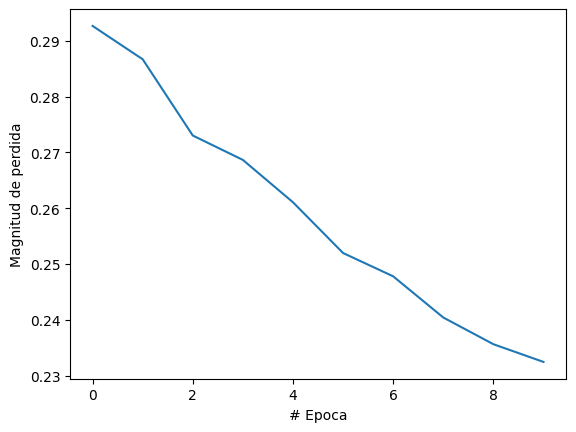

In [ ]:
#Resultado de la funcion de perdida en cada epoca
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de perdida")
plt.plot(historial.history["loss"])

1/1 [==============================] - 0s 19ms/step


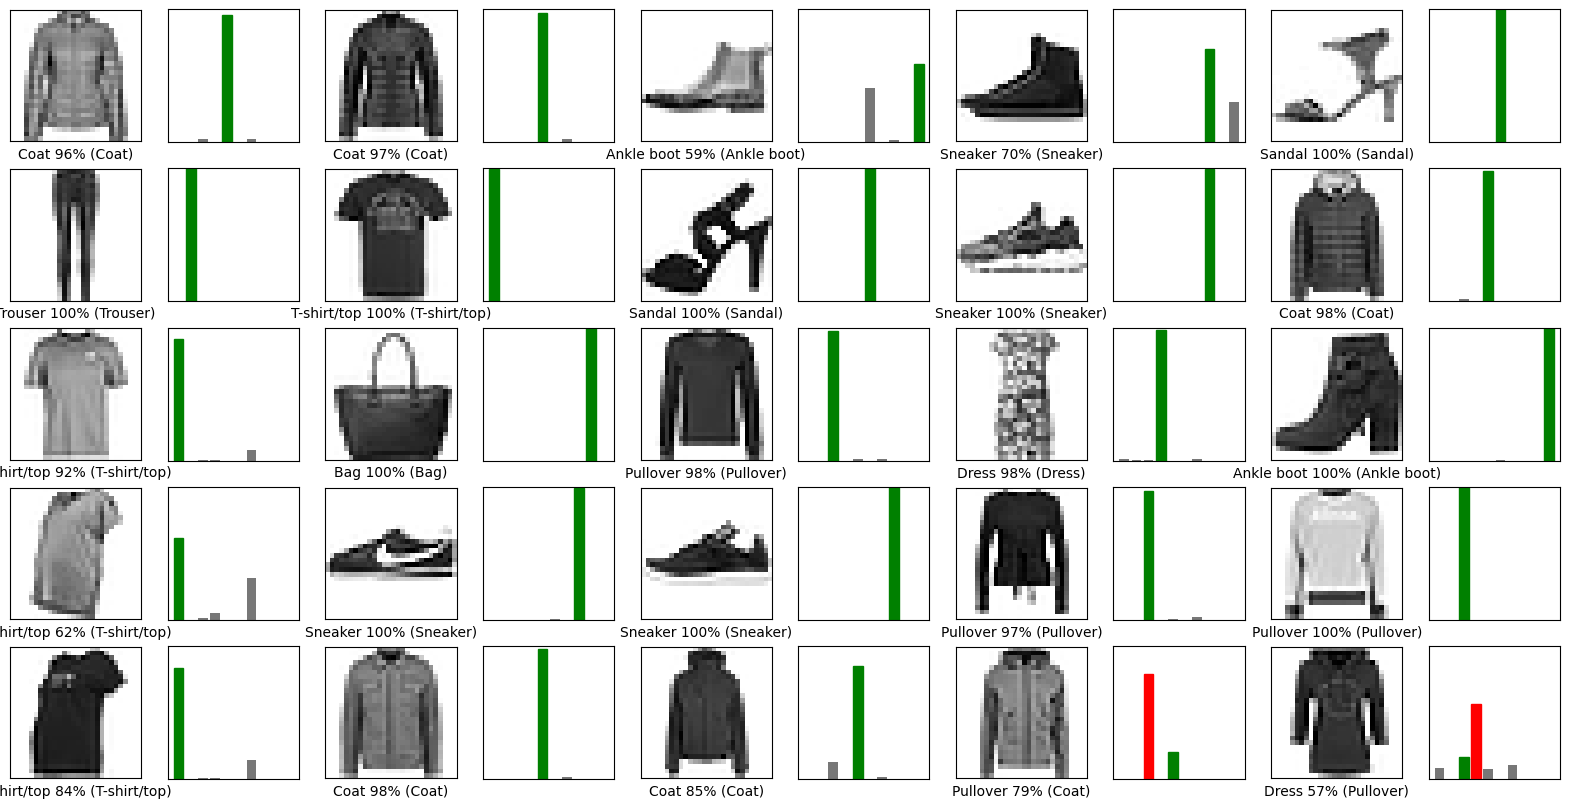

In [17]:
#Empezamos con las predicciones, primero de 25 imagenes del set de prueba para que intente predecir cada uno
#Si acierta mostrara una barra verde, si falla mostrara una barra roja al lado de cada imagen de prueba
import numpy as np

for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = modelo.predict(imagenes_prueba)

def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[..., 0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'green' #si acerto prediccion
  else:
    color = 'red' #no acerto prediccion

  plt.xlabel("{} {:2.0f}% ({})".format(
      nombres_clases[etiqueta_prediccion],
      100*np.max(arr_predicciones),
      nombres_clases[etiqueta_real],
      color=color
  ))

def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0,1])
  etiqueta_prediccion = np.argmax(arr_predicciones)

  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('green')

filas =5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)